In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import glob
import os
import jsonpickle

In [4]:
# get all files under src/round1
files = glob.glob('src/round4/round-4-island-data-bottle/*.csv')
files

['src/round4/round-4-island-data-bottle\\prices_round_4_day_1.csv',
 'src/round4/round-4-island-data-bottle\\prices_round_4_day_2.csv',
 'src/round4/round-4-island-data-bottle\\prices_round_4_day_3.csv',
 'src/round4/round-4-island-data-bottle\\trades_round_4_day_1_nn.csv',
 'src/round4/round-4-island-data-bottle\\trades_round_4_day_2_nn.csv',
 'src/round4/round-4-island-data-bottle\\trades_round_4_day_3_nn.csv']

In [5]:
prices = []
trades = []
for file in files:
    if 'prices' in file:
        prices.append(pd.read_csv(file,sep=';',index_col=0))
    else:
        trades.append(pd.read_csv(file,sep=';',index_col=0))
prices = pd.concat(prices).sort_values(['day','timestamp']).reset_index()
trades = pd.concat(trades,keys=[1,2,3],names=['day']).reset_index()

In [6]:
prices

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,1,0,COCONUT,9999.0,200.0,NaN,NaN,NaN,NaN,10001,200,NaN,NaN,NaN,NaN,10000.0,0.0
1,1,0,COCONUT_COUPON,637.0,39.0,NaN,NaN,NaN,NaN,638,39,NaN,NaN,NaN,NaN,637.5,0.0
2,1,100,COCONUT,9999.0,104.0,9998.0,44.0,NaN,NaN,10000,104,10001.0,44.0,NaN,NaN,9999.5,0.0
3,1,100,COCONUT_COUPON,637.0,33.0,NaN,NaN,NaN,NaN,638,33,NaN,NaN,NaN,NaN,637.5,0.0
4,1,200,COCONUT,9998.0,133.0,9997.0,62.0,NaN,NaN,9999,133,10000.0,62.0,NaN,NaN,9998.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,3,999700,COCONUT_COUPON,575.0,40.0,NaN,NaN,NaN,NaN,576,40,NaN,NaN,NaN,NaN,575.5,0.0
59996,3,999800,COCONUT_COUPON,575.0,30.0,NaN,NaN,NaN,NaN,576,44,NaN,NaN,NaN,NaN,575.5,0.0
59997,3,999800,COCONUT,9883.0,127.0,9882.0,46.0,NaN,NaN,9885,164,NaN,NaN,NaN,NaN,9884.0,0.0
59998,3,999900,COCONUT_COUPON,575.0,43.0,NaN,NaN,NaN,NaN,576,43,NaN,NaN,NaN,NaN,575.5,0.0


In [7]:
prices.set_index(['day','timestamp'],inplace=True)

In [8]:
coco = prices[prices['product']=='COCONUT']
coco_cou = prices[prices['product']=='COCONUT_COUPON']

In [9]:
# find the na
coco.isna().sum()

product                0
bid_price_1            0
bid_volume_1           0
bid_price_2         7013
bid_volume_2        7013
bid_price_3        29956
bid_volume_3       29956
ask_price_1            0
ask_volume_1           0
ask_price_2         7579
ask_volume_2        7579
ask_price_3        29625
ask_volume_3       29625
mid_price              0
profit_and_loss        0
dtype: int64

In [10]:
coco_cou.isna().sum()

product                0
bid_price_1            2
bid_volume_1           2
bid_price_2        29406
bid_volume_2       29406
bid_price_3        30000
bid_volume_3       30000
ask_price_1            0
ask_volume_1           0
ask_price_2        29450
ask_volume_2       29450
ask_price_3        30000
ask_volume_3       30000
mid_price              0
profit_and_loss        0
dtype: int64

In [11]:
coco.loc[:,'bid_price_1']=coco['bid_price_1'].ffill()
coco_cou.loc[:,'bid_price_1']=coco_cou['bid_price_1'].ffill()

In [12]:
coco.loc[:,'mid_price'] = (coco['bid_price_1'] + coco['ask_price_1']) / 2
coco_cou.loc[:,'mid_price'] = (coco_cou['bid_price_1'] + coco_cou['ask_price_1']) / 2

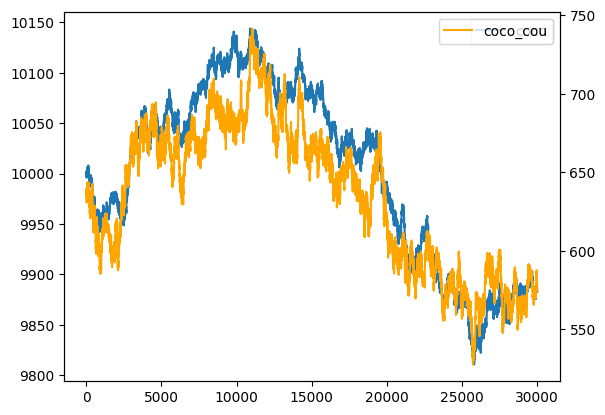

In [13]:
# plot coco and coco_cou on the same plot with different y-axis, same x-axis
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(coco['mid_price'].values,label='coco')
ax2.plot(coco_cou['mid_price'].values,label='coco_cou',color='orange')
ax1.legend()
ax2.legend()
plt.show()

# Method 1: pairs trading

In [14]:
coco_cou.loc[:,'mid_price_delay']=coco_cou['mid_price'].shift(1).bfill()

C:\Users\kevin\AppData\Local\Temp\ipykernel_13884\2488072776.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coco_cou.loc[:,'mid_price_delay']=coco_cou['mid_price'].shift(1).bfill()


In [15]:
coco_cou

product  bid_price_1  bid_volume_1  bid_price_2  \
day timestamp                                                           
1   0          COCONUT_COUPON        637.0          39.0          NaN   
    100        COCONUT_COUPON        637.0          33.0          NaN   
    200        COCONUT_COUPON        637.0          42.0          NaN   
    300        COCONUT_COUPON        638.0          30.0          NaN   
    400        COCONUT_COUPON        637.0          33.0          NaN   
...                       ...          ...           ...          ...   
3   999500     COCONUT_COUPON        577.0          45.0          NaN   
    999600     COCONUT_COUPON        577.0          30.0          NaN   
    999700     COCONUT_COUPON        575.0          40.0          NaN   
    999800     COCONUT_COUPON        575.0          30.0          NaN   
    999900     COCONUT_COUPON        575.0          43.0          NaN   

               bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  \
day timestamp                                                         
1   0                   NaN          NaN           NaN          638   
    100                 NaN          NaN           NaN          638   
    200                 NaN          NaN           NaN          638   
    300                 NaN          NaN           NaN          639   
    400                 NaN          NaN           NaN          638   
...                     ...          ...           ...          ...   
3   999500              NaN          NaN           NaN          578   
    999600              NaN          NaN           NaN          578   
    999700              NaN          NaN           NaN          576   
    999800              NaN          NaN           NaN          576   
    999900              NaN          NaN           NaN          576   

               ask_volume_1  ask_price_2  ask_volume_2  ask_price_3  \
day timestamp                                                         
1   0                    39          NaN           NaN          NaN   
    100                  33          NaN           NaN          NaN   
    200                  42          NaN           NaN          NaN   
    300                  30          NaN           NaN          NaN   
    400                  33          NaN           NaN          NaN   
...                     ...          ...           ...          ...   
3   999500               45          NaN           NaN          NaN   
    999600               30          NaN           NaN          NaN   
    999700               40          NaN           NaN          NaN   
    999800               44          NaN           NaN          NaN   
    999900               43          NaN           NaN          NaN   

               ask_volume_3  mid_price  profit_and_loss  mid_price_delay  
day timestamp                                                             
1   0                   NaN      637.5              0.0            637.5  
    100                 NaN      637.5              0.0            637.5  
    200                 NaN      637.5              0.0            637.5  
    300                 NaN      638.5              0.0            637.5  
    400                 NaN      637.5              0.0            638.5  
...                     ...        ...              ...              ...  
3   999500              NaN      577.5              0.0            577.5  
    999600              NaN      577.5              0.0            577.5  
    999700              NaN      575.5              0.0            577.5  
    999800              NaN      575.5              0.0            575.5  
    999900              NaN      575.5              0.0            575.5  

[30000 rows x 16 columns]

In [16]:
from utils import ols
ols_res = ols(coco.loc[:,'mid_price'],coco_cou.loc[:,['mid_price']],intercept=True)

In [17]:
ols_res

{'coefficients': array([1.82459034]),
 'intercept': 8841.201392746636,
 't_stats': array([4395.78098955,  577.64552084]),
 'p_values': array([0., 0.]),
 'R2': 0.9175136625440903,
 'residuals': array([-4.37773738, -4.87773738, -5.87773738, ..., -7.75313602,
        -7.25313602, -8.75313602])}

In [18]:
ols2_res = ols(coco_cou.loc[:,'mid_price'],coco.loc[:,['mid_price']],intercept=True)

In [19]:
ols2_res

{'coefficients': array([0.50286009]),
 'intercept': -4393.50466244335,
 't_stats': array([-504.67585781,  577.64552084]),
 'p_values': array([0., 0.]),
 'R2': 0.9175136625440905,
 'residuals': array([ 2.40377514,  2.65520518,  3.15806527, ..., -1.01302453,
        -1.26445457, -0.51016444])}

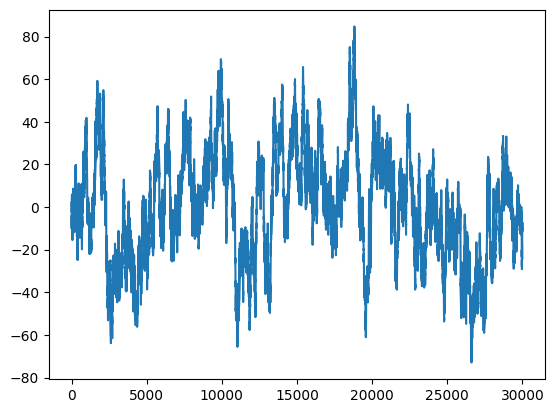

In [20]:
plt.plot(ols_res['residuals'])
# plt.plot(-ols2_res['residuals'])

In [211]:
np.mean(ols_res['residuals'])

1.106915685037772e-12

In [212]:
np.std(ols_res['residuals'])

25.490151318439462

In [228]:
np.mean(ols2_res['residuals'])

9.503613303725918e-13

In [229]:
np.std(ols2_res['residuals'])

13.381762301052223

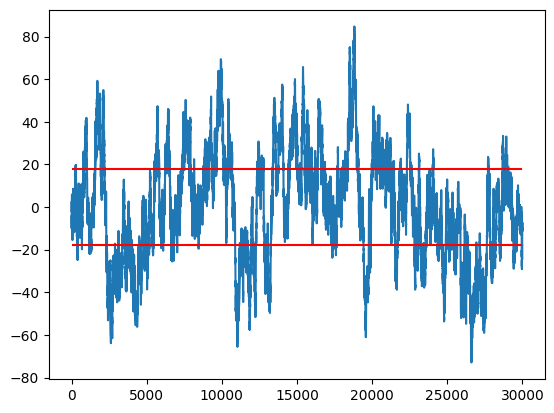

In [22]:
plt.plot(ols_res['residuals'])
plt.hlines(np.std(ols_res['residuals'])*0.7,0,30_000,colors='r')
plt.hlines(-np.std(ols_res['residuals'])*0.7,0,30_000,colors='r')

In [224]:
np.diff(ols_res['residuals'][900:950][::-1])

array([-0.32459034, -2.        ,  1.32459034, -0.5       ,  1.32459034,
       -1.5       ,  1.82459034,  0.        ,  1.        , -0.82459034,
       -2.32459034,  0.32459034,  1.32459034, -0.82459034,  0.        ,
       -1.64918069,  2.64918069,  0.        , -1.5       , -0.5       ,
        1.        , -2.32459034,  0.82459034, -0.5       , -2.32459034,
       -3.14918069, -3.64918069,  1.5       ,  1.82459034,  1.08770483,
        2.73688552,  0.73688552,  2.73688552, -1.82459034, -1.        ,
        2.        , -1.82459034, -0.91229517, -2.73688552,  3.14918069,
       -0.5       , -2.82459034,  0.        ,  1.23688552,  0.58770483,
        0.32459034, -1.32459034,  1.        , -1.        ])

In [205]:
import statsmodels.api as sm
ar_model = sm.tsa.AutoReg(ols_res['residuals'], lags=1).fit()

In [206]:
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                30000
Model:                     AutoReg(1)   Log Likelihood              -62430.926
Method:               Conditional MLE   S.D. of innovations              1.939
Date:                Sat, 20 Apr 2024   AIC                         124867.851
Time:                        07:45:16   BIC                         124892.778
Sample:                             1   HQIC                        124875.849
                                30000                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.011     -0.013      0.990      -0.022       0.022
y.L1           0.9971      0.000   2270.385      0.000       0.996       0.998
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0029           +0.0000j            1.0029            0.0000
-----------------------------------------------------------------------------
"""

In [203]:
ols2_res

{'coefficients': array([1.82459034, 1.        ]),
 'intercept': 8841.201392746649,
 't_stats': array([7.33057340e+16, 9.63303881e+15, 2.88833824e+15]),
 'p_values': array([0., 0., 0.]),
 'R2': 1.0,
 'residuals': array([1.8189894e-12, 1.8189894e-12, 1.8189894e-12, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00])}

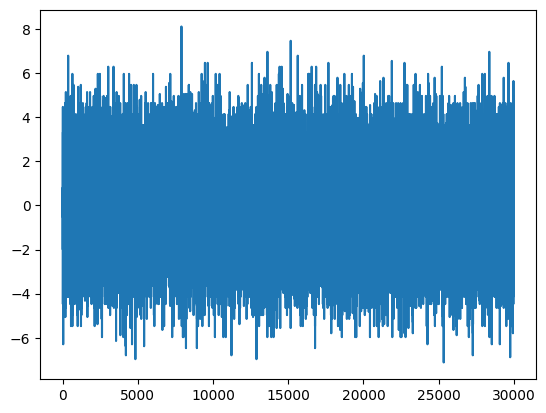

In [21]:
plt.plot(np.diff(ols_res['residuals']))

In [182]:
res_diff = np.diff(ols_res['residuals'])

(array([3.000e+00, 1.000e+00, 3.000e+00, 0.000e+00, 5.000e+00, 5.000e+00,
        1.000e+00, 2.300e+01, 8.000e+00, 4.000e+00, 4.200e+01, 6.000e+00,
        3.000e+01, 9.000e+00, 4.800e+01, 7.000e+00, 9.500e+01, 8.200e+01,
        2.000e+01, 1.920e+02, 1.040e+02, 5.600e+01, 3.700e+02, 7.900e+01,
        1.610e+02, 8.100e+01, 4.830e+02, 4.700e+01, 5.200e+02, 4.410e+02,
        1.080e+02, 7.970e+02, 4.670e+02, 2.010e+02, 1.381e+03, 3.000e+02,
        4.970e+02, 2.230e+02, 1.321e+03, 1.600e+02, 1.373e+03, 1.100e+03,
        2.360e+02, 1.512e+03, 9.020e+02, 3.240e+02, 2.083e+03, 4.830e+02,
        6.120e+02, 1.850e+03, 1.750e+02, 1.280e+02, 1.408e+03, 1.040e+03,
        2.050e+02, 1.458e+03, 4.640e+02, 1.990e+02, 1.423e+03, 3.030e+02,
        3.340e+02, 9.950e+02, 7.100e+01, 7.100e+01, 5.540e+02, 4.230e+02,
        7.400e+01, 5.060e+02, 1.540e+02, 5.600e+01, 3.730e+02, 7.500e+01,
        6.300e+01, 2.190e+02, 1.100e+01, 2.100e+01, 9.500e+01, 8.000e+01,
        7.000e+00, 5.700e+01, 1.500e+0

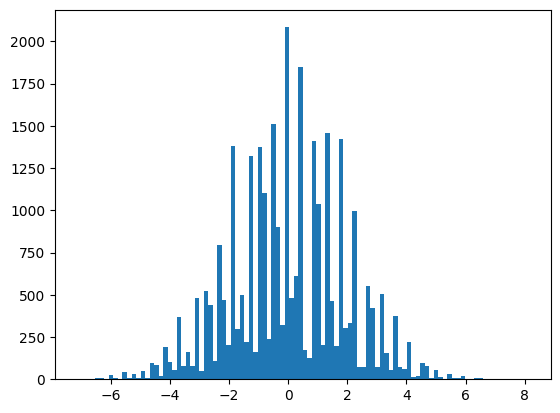

In [183]:
plt.hist(res_diff,bins=100)

In [167]:
# fit a MA1 model on the np.diff(residuals)
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(ols_res['residuals'][:10000],order=(0,1,1))

In [168]:
model_fit = model.fit()

In [169]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                10000
Model:                 ARIMA(0, 1, 1)   Log Likelihood              -20881.417
Date:                Sat, 20 Apr 2024   AIC                          41766.835
Time:                        05:35:16   BIC                          41781.255
Sample:                             0   HQIC                         41771.716
                              - 10000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0687      0.010     -6.892      0.000      -0.088      -0.049
sigma2         3.8145      0.055     68.992      0.000       3.706       3.923
Ljung-Box (L1) (Q):                   0.01   Jarque-

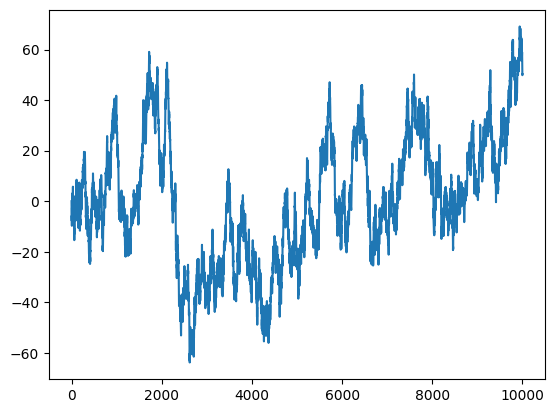

In [175]:
plt.plot(model_fit.predict())

In [176]:
ols_res['residuals'][10002]-ols_res['residuals'][10001]

0.5

In [165]:
# fit a MA1 model on the np.diff(residuals)
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(ols_res['residuals'], order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                30000
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -62353.241
Date:                Sat, 20 Apr 2024   AIC                         124714.481
Time:                        05:32:35   BIC                         124747.717
Sample:                             0   HQIC                        124725.145
                              - 30000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.075e-07      4.184  -1.69e-07      1.000      -8.201       8.201
ar.L1          0.9975      0.000   2459.873      0.000       0.997       0.998
ma.L1         -0.0744      0.006    -12.899      0.0

In [162]:
model_fit.params

array([-0.07573048,  3.74385762])

In [163]:
model_fit.param_names

['ma.L1', 'sigma2']

In [164]:
a={}
list(a.keys())[0]

IndexError: list index out of range

In [ ]:
model_fit.plot_diagnostics()

In [ ]:
plt.hist(model_fit.resid,bins=100)

In [ ]:
spread = coco.loc[:,'mid_price']-ols_res['intercept'] - coco_cou.loc[:,'mid_price'] * ols_res['coefficients'][0]

In [ ]:
spread.plot()

In [ ]:
# extending window standard deviation
spread.rolling(100).std().plot()

# Method 2: Implied volatility
## given coconut price, implied volatility, calculate the price of coconut coupon
## given coconut price and coconut coupon price, calculate the implied volatility

# calibrate k

In [231]:
better = pd.read_csv('src/round4/better.csv',sep=';',index_col=0)

In [232]:
worse = pd.read_csv('src/round4/worse.csv',sep=';',index_col=0)

In [235]:
better[better['product']=='COCONUT']

,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
day,,,,,,,,,,,,,,,,
3,0,COCONUT,9990,136,9989.0,49.0,NaN,NaN,9992,185,NaN,NaN,NaN,NaN,9991.0,0.00
3,100,COCONUT,9989,143,NaN,NaN,NaN,NaN,9991,101,9992.0,42.0,NaN,NaN,9990.0,0.00
3,200,COCONUT,9990,99,9989.0,67.0,NaN,NaN,9991,105,9992.0,67.0,NaN,NaN,9990.5,0.00
3,300,COCONUT,9991,114,9990.0,42.0,NaN,NaN,9992,114,9993.0,42.0,NaN,NaN,9991.5,0.00
3,400,COCONUT,9989,129,9988.0,71.0,NaN,NaN,9991,200,NaN,NaN,NaN,NaN,9990.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,99500,COCONUT,9960,172,NaN,NaN,NaN,NaN,9962,128,9963.0,44.0,NaN,NaN,9961.0,8705.50
3,99600,COCONUT,9960,135,9959.0,63.0,NaN,NaN,9961,135,9962.0,63.0,NaN,NaN,9960.5,8923.75
3,99700,COCONUT,9962,146,9961.0,56.0,NaN,NaN,9963,146,9964.0,56.0,NaN,NaN,9962.5,8307.25


In [242]:
worse[worse['product']=='COCONUT']

,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
day,,,,,,,,,,,,,,,,
3,0,COCONUT,9990,136,9989.0,49.0,NaN,NaN,9992,185,NaN,NaN,NaN,NaN,9991.0,0.00
3,100,COCONUT,9989,143,NaN,NaN,NaN,NaN,9991,101,9992.0,42.0,NaN,NaN,9990.0,0.00
3,200,COCONUT,9990,99,9989.0,67.0,NaN,NaN,9991,105,9992.0,67.0,NaN,NaN,9990.5,0.00
3,300,COCONUT,9991,114,9990.0,42.0,NaN,NaN,9992,114,9993.0,42.0,NaN,NaN,9991.5,0.00
3,400,COCONUT,9989,129,9988.0,71.0,NaN,NaN,9991,200,NaN,NaN,NaN,NaN,9990.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,99500,COCONUT,9960,172,NaN,NaN,NaN,NaN,9962,128,9963.0,44.0,NaN,NaN,9961.0,8159.50
3,99600,COCONUT,9960,135,9959.0,63.0,NaN,NaN,9961,135,9962.0,63.0,NaN,NaN,9960.5,8377.75
3,99700,COCONUT,9962,146,9961.0,56.0,NaN,NaN,9963,146,9964.0,56.0,NaN,NaN,9962.5,7761.25


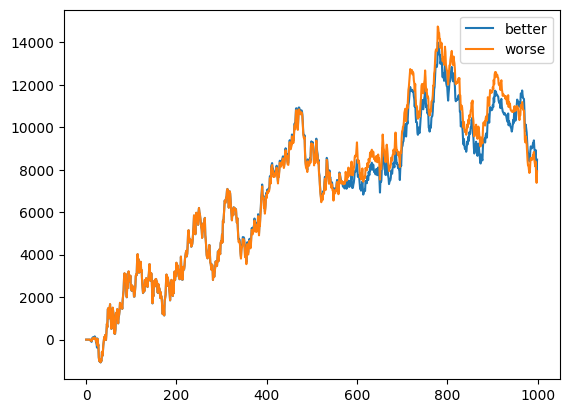

In [253]:
plt.plot(better[better['product']=='COCONUT']['profit_and_loss'].reset_index(drop=True),label='better')
plt.plot(worse[worse['product']=='COCONUT']['profit_and_loss'].reset_index(drop=True),label='worse')
plt.legend()
plt.show()

In [257]:
def zen_metric(df,k=0.6):
    ret = df['profit_and_loss'].mean()
    sharpe = ret / df['profit_and_loss'].std()
    return ret**(1-k)*sharpe**k

In [258]:
zen_metric(better[better['product']=='COCONUT'])

52.04101261182657

In [259]:
zen_metric(worse[worse['product']=='COCONUT'])

51.78106794673643